In [1]:
import datetime
from qiskit_finance import QiskitFinanceError
from qiskit_finance.data_providers import YahooDataProvider
import matplotlib.pyplot as plt
from qiskit_algorithms import SamplingVQE, NumPyMinimumEigensolver
from qiskit_algorithms.optimizers import COBYLA
from qiskit_finance.applications.optimization import PortfolioOptimization
from qiskit.primitives import Sampler
from qiskit.circuit.library import RealAmplitudes
from qiskit_optimization.algorithms import MinimumEigenOptimizer
import numpy as np

In [2]:
def get_data(tickers, start_date, end_date):
    try:
        data = YahooDataProvider(tickers=tickers,
                                start=start_date,
                                end=end_date)
        data.run()
        return data
    except QiskitFinanceError as ex:
        print(ex)
        return None
    
def plot_data(data, ax, title):
    for (cnt, s) in enumerate(data._tickers):
        ax.plot(data._data[cnt], label=s)
    ax.legend(ncol=1,loc="upper center", bbox_to_anchor=(1, 1))
    ax.set_title(title)
    ax.set_xlabel('Date')
    ax.set_ylabel('Price')
    ax.grid()

def fill_in_missing(data):
    for (cnt, s) in enumerate(data._tickers):
        print(f'{s}')
        print(f'Null values:{data._data[cnt].isnull().sum()}', end=' /')
        # Sustituir el valor NaN por el valor anterior
        data._data[cnt].interpolate(inplace=True)
        data._data[cnt].ffill(inplace=True)
        data._data[cnt].bfill(inplace=True)
        print(f' After:{data._data[cnt].isnull().sum()}')

def plot_covariance_matrix(sigma, ax, title):
    ax.imshow(sigma, interpolation="nearest")
    ax.set_title(title)

def plot_mu(data, mu, ax, title):
    # Plot the expected return in a lolipop plot
    ax.stem(mu)
    ax.set_xticks(range(len(mu)))
    ax.set_xticklabels(data._tickers, rotation=45)
    ax.set_xlabel("Stock")
    ax.set_ylabel("Expected return")
    ax.set_title(title)

def prepare_portfolio_optimization(risk_factor, budget, mu, sigma):
    portfolio = PortfolioOptimization(
        expected_returns=mu, covariances=sigma, risk_factor=risk_factor, budget=budget
    )
    qp = portfolio.to_quadratic_program()
    return portfolio, qp
    

def optimize(qp, ansatz, optimizer):
    svqe_mes = SamplingVQE(sampler=Sampler(), ansatz=ansatz, optimizer=optimizer)
    svqe = MinimumEigenOptimizer(svqe_mes)
    result = svqe.solve(qp)
    return result

def interpret_results(result, portfolio, data):
    selected = portfolio.interpret(result)
    print("\tSelected stocks:")
    print("\t", end="")
    for s in selected:
        print(f" - {data._tickers[s]}", end="")
    print()
    print('\tExpected value: ',round(portfolio.portfolio_expected_value(result),5),end=" ")
    print('Variance: ',round(portfolio.portfolio_variance(result),5))

def get_interval_yearly(start_date, end_date):
    intervals = []
    for i in range(start_date.year, end_date.year+1):
        intervals.append((datetime.datetime(i,1,1), datetime.datetime(i,12,31)))
    return intervals
def get_interval_6months(start_date, end_date):
    intervals = []
    for i in range(start_date.year, end_date.year+1):
        intervals.append((datetime.datetime(i,1,1), datetime.datetime(i,6,30)))
        intervals.append((datetime.datetime(i,7,1), datetime.datetime(i,12,31)))
    return intervals
def get_interval_quarterly(start_date, end_date):
    intervals = []
    for i in range(start_date.year, end_date.year+1):
        intervals.append((datetime.datetime(i,1,1), datetime.datetime(i,3,31)))
        intervals.append((datetime.datetime(i,4,1), datetime.datetime(i,6,30)))
        intervals.append((datetime.datetime(i,7,1), datetime.datetime(i,9,30)))
        intervals.append((datetime.datetime(i,10,1), datetime.datetime(i,12,31)))
    return intervals

In [3]:
# ibex35, s&p500, nasdaq, FTSE 100, Nikkei 225, DAX, CAC 40, Hang Seng Index, Shanghai Composite, eurostoxx50, bovespa, omx stockholm 30, aex, moex

ticker_names = {
    # Indexes
    '^IBEX' : 'IBEX 35',
    '^GSPC' : 'S&P 500',
    '^IXIC' : 'Nasdaq',
    '^FTSE' : 'FTSE 100',
    '^N225' : 'Nikkei 225',
    '^GDAXI' : 'DAX',
    '^FCHI' : 'CAC 40',
    '^HSI' : 'Hang Seng Index',
    '000001.SS' : 'Shanghai Composite',
    '^STOXX50E' : 'Eurostoxx 50',
    '^BVSP' : 'Bovespa',
    '^OMX' : 'OMX Stockholm 30',
    '^AEX' : 'AEX',
    'IMOEX.ME' : 'MOEX'
}

In [4]:
start_date = datetime.datetime(2014, 1, 1)
end_date = datetime.datetime(2023, 12, 31)

In [5]:
#intervals =[(start_date, end_date)]
intervals = get_interval_yearly(start_date, end_date)

for (i, interval) in enumerate(intervals):
    print(f"Intervalo {i+1}: {interval[0].date()} - {interval[1].date()}", end="/ ")
    if (i+1)%4 == 0:
        print()

Intervalo 1: 2014-01-01 - 2014-12-31/ Intervalo 2: 2015-01-01 - 2015-12-31/ Intervalo 3: 2016-01-01 - 2016-12-31/ Intervalo 4: 2017-01-01 - 2017-12-31/ 
Intervalo 5: 2018-01-01 - 2018-12-31/ Intervalo 6: 2019-01-01 - 2019-12-31/ Intervalo 7: 2020-01-01 - 2020-12-31/ Intervalo 8: 2021-01-01 - 2021-12-31/ 
Intervalo 9: 2022-01-01 - 2022-12-31/ Intervalo 10: 2023-01-01 - 2023-12-31/ 

In [6]:
data_set = []
for start_date, end_date in intervals:
    data = get_data(list(ticker_names.keys()), start_date, end_date)
    data_set.append(data)

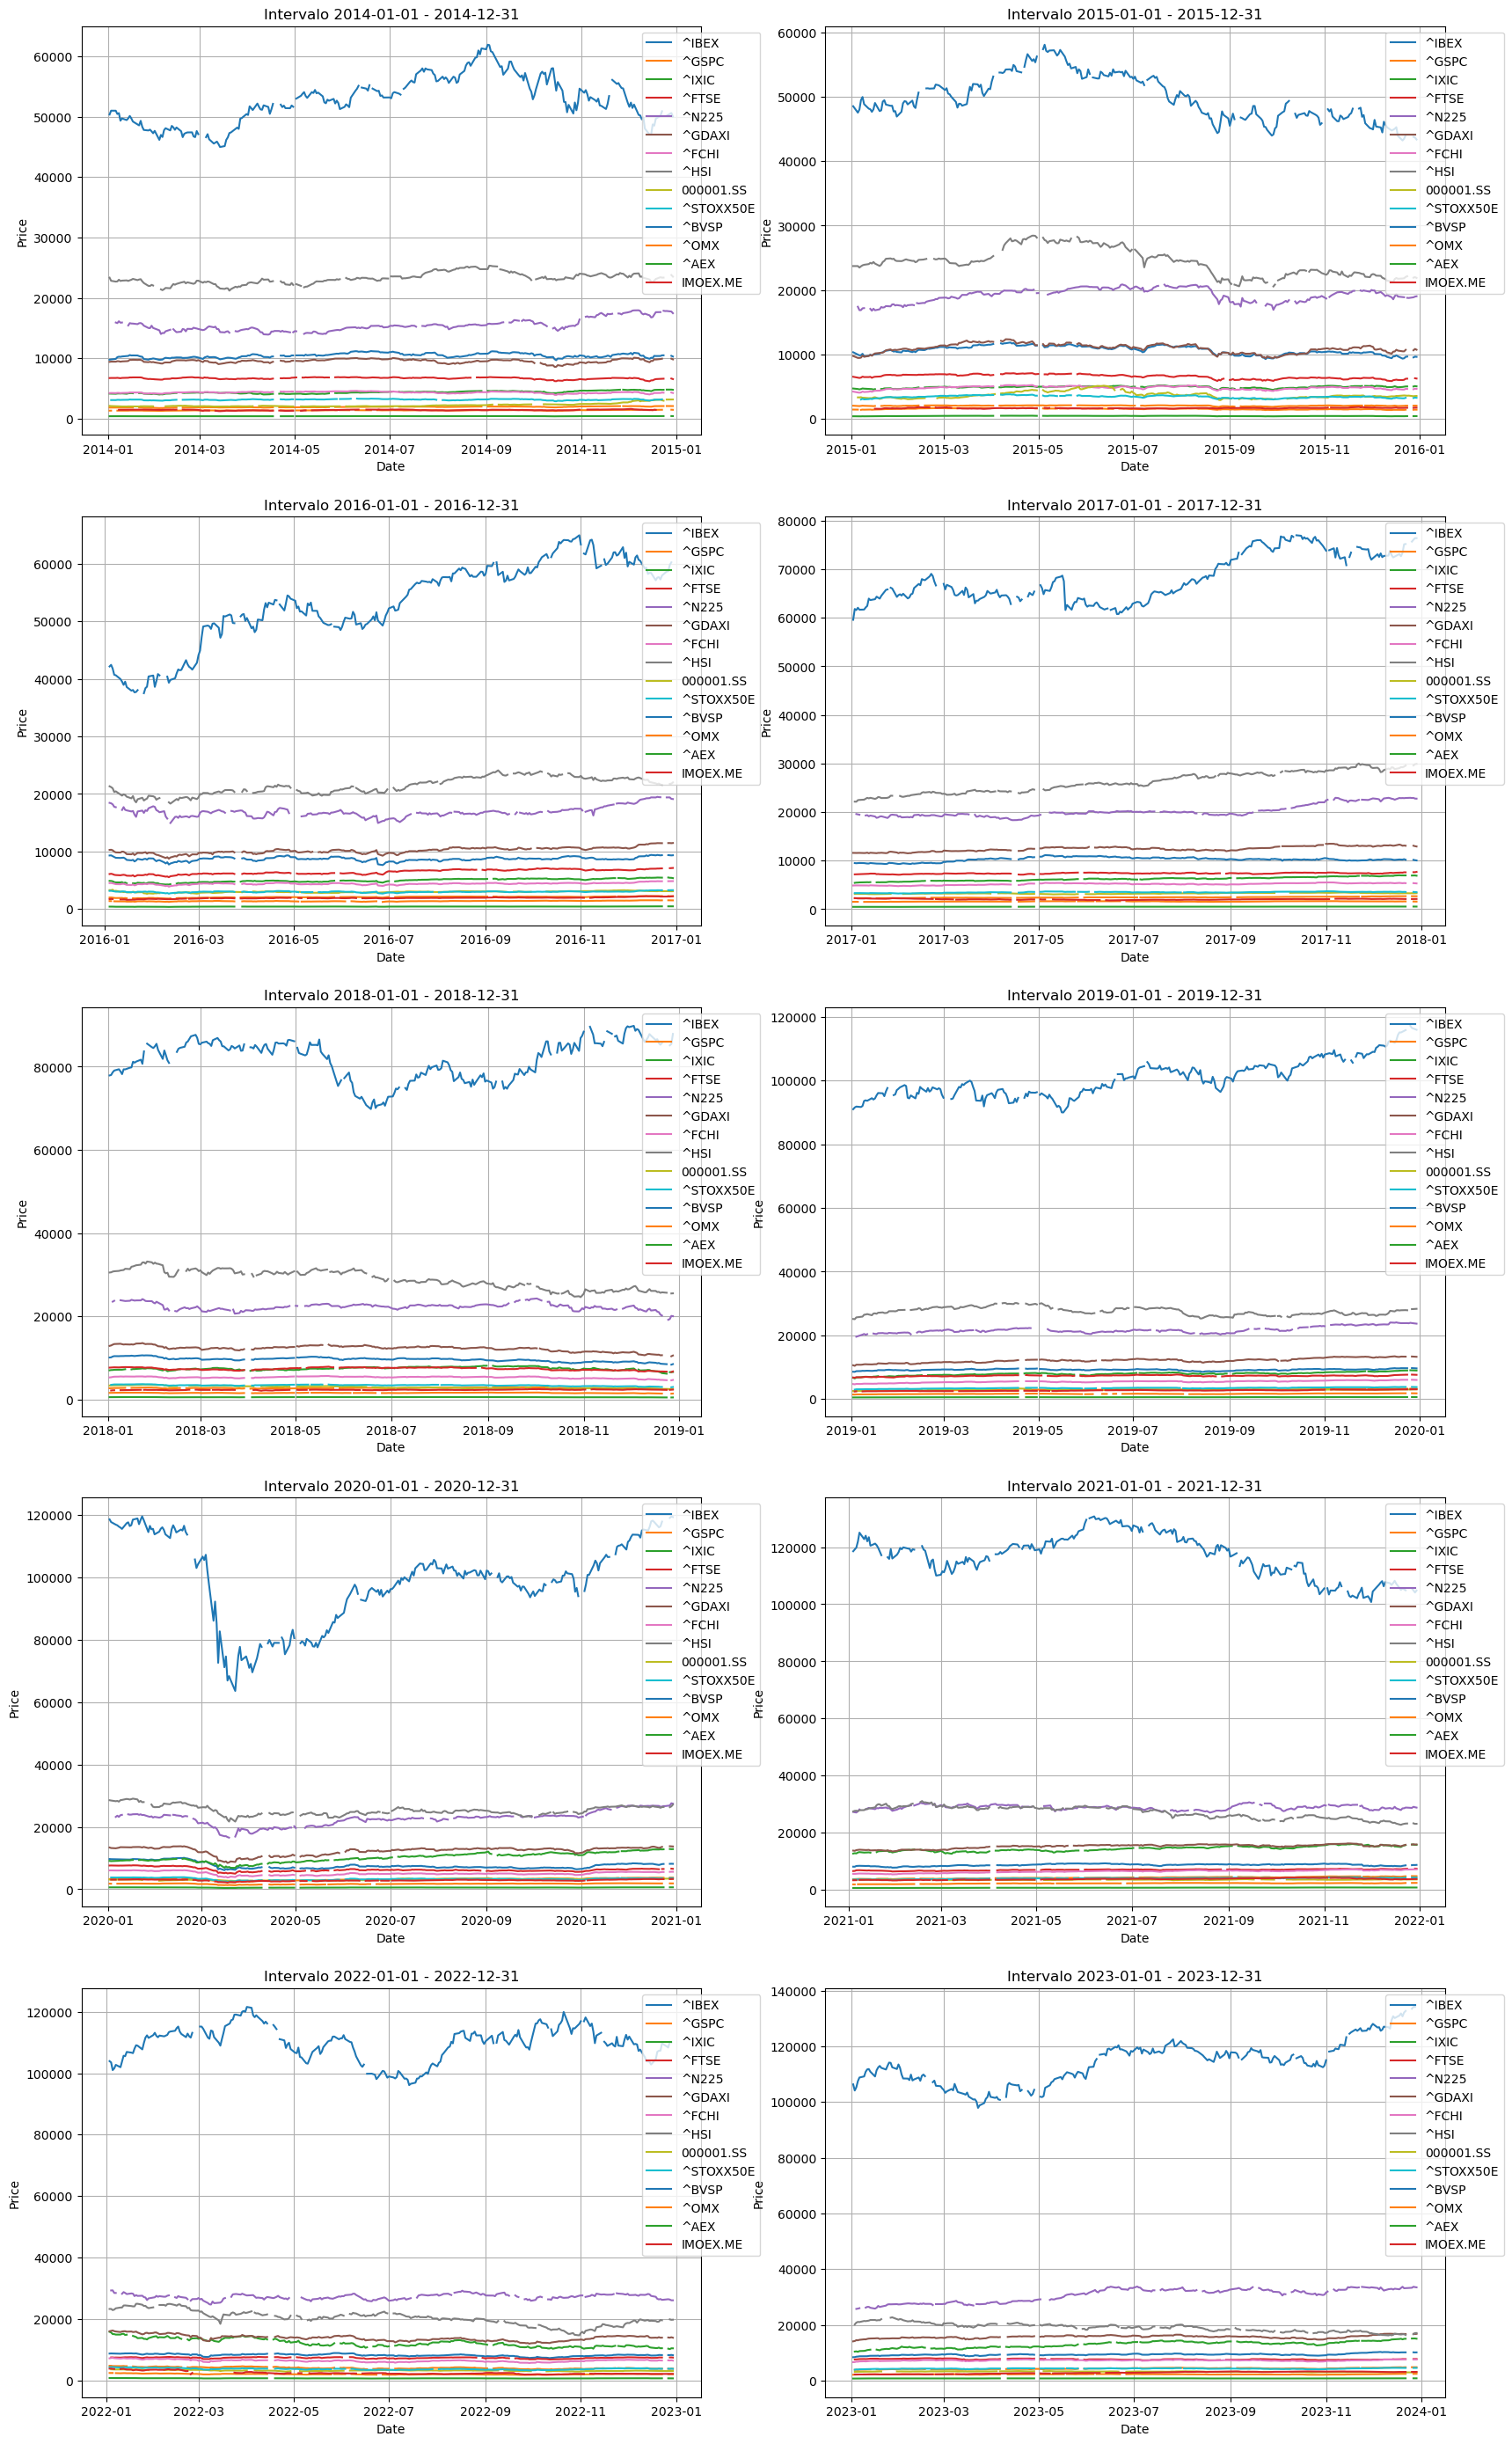

In [7]:
n_cols = 2
n_rows = max(len(data_set) // n_cols,1)
fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 7*n_rows))

for data, interval in zip(data_set, intervals):
    title = f"Intervalo {interval[0].date()} - {interval[1].date()}"
    i, j = divmod(intervals.index(interval), n_cols)
    if n_rows == 1:
        plot_data(data, axs[j], title)
    else:
        plot_data(data, axs[i, j], title)

In [8]:
# Fill if missing values
for data, interval in zip(data_set, intervals):
    print(f"Intervalo {interval[0].date()} - {interval[1].date()}")
    fill_in_missing(data)


Intervalo 2014-01-01 - 2014-12-31
^IBEX
Null values:5 / After:0
^GSPC
Null values:8 / After:0
^IXIC
Null values:8 / After:0
^FTSE
Null values:7 / After:0
^N225
Null values:15 / After:0
^GDAXI
Null values:7 / After:0
^FCHI
Null values:5 / After:0
^HSI
Null values:13 / After:0
000001.SS
Null values:16 / After:0
^STOXX50E
Null values:12 / After:0
^BVSP
Null values:11 / After:0
^OMX
Null values:10 / After:0
^AEX
Null values:5 / After:0
IMOEX.ME
Null values:20 / After:0
Intervalo 2015-01-01 - 2015-12-31
^IBEX
Null values:4 / After:0
^GSPC
Null values:8 / After:0
^IXIC
Null values:8 / After:0
^FTSE
Null values:7 / After:0
^N225
Null values:15 / After:0
^GDAXI
Null values:6 / After:0
^FCHI
Null values:4 / After:0
^HSI
Null values:13 / After:0
000001.SS
Null values:16 / After:0
^STOXX50E
Null values:9 / After:0
^BVSP
Null values:13 / After:0
^OMX
Null values:8 / After:0
^AEX
Null values:4 / After:0
IMOEX.ME
Null values:18 / After:0
Intervalo 2016-01-01 - 2016-12-31
^IBEX
Null values:3 / After:

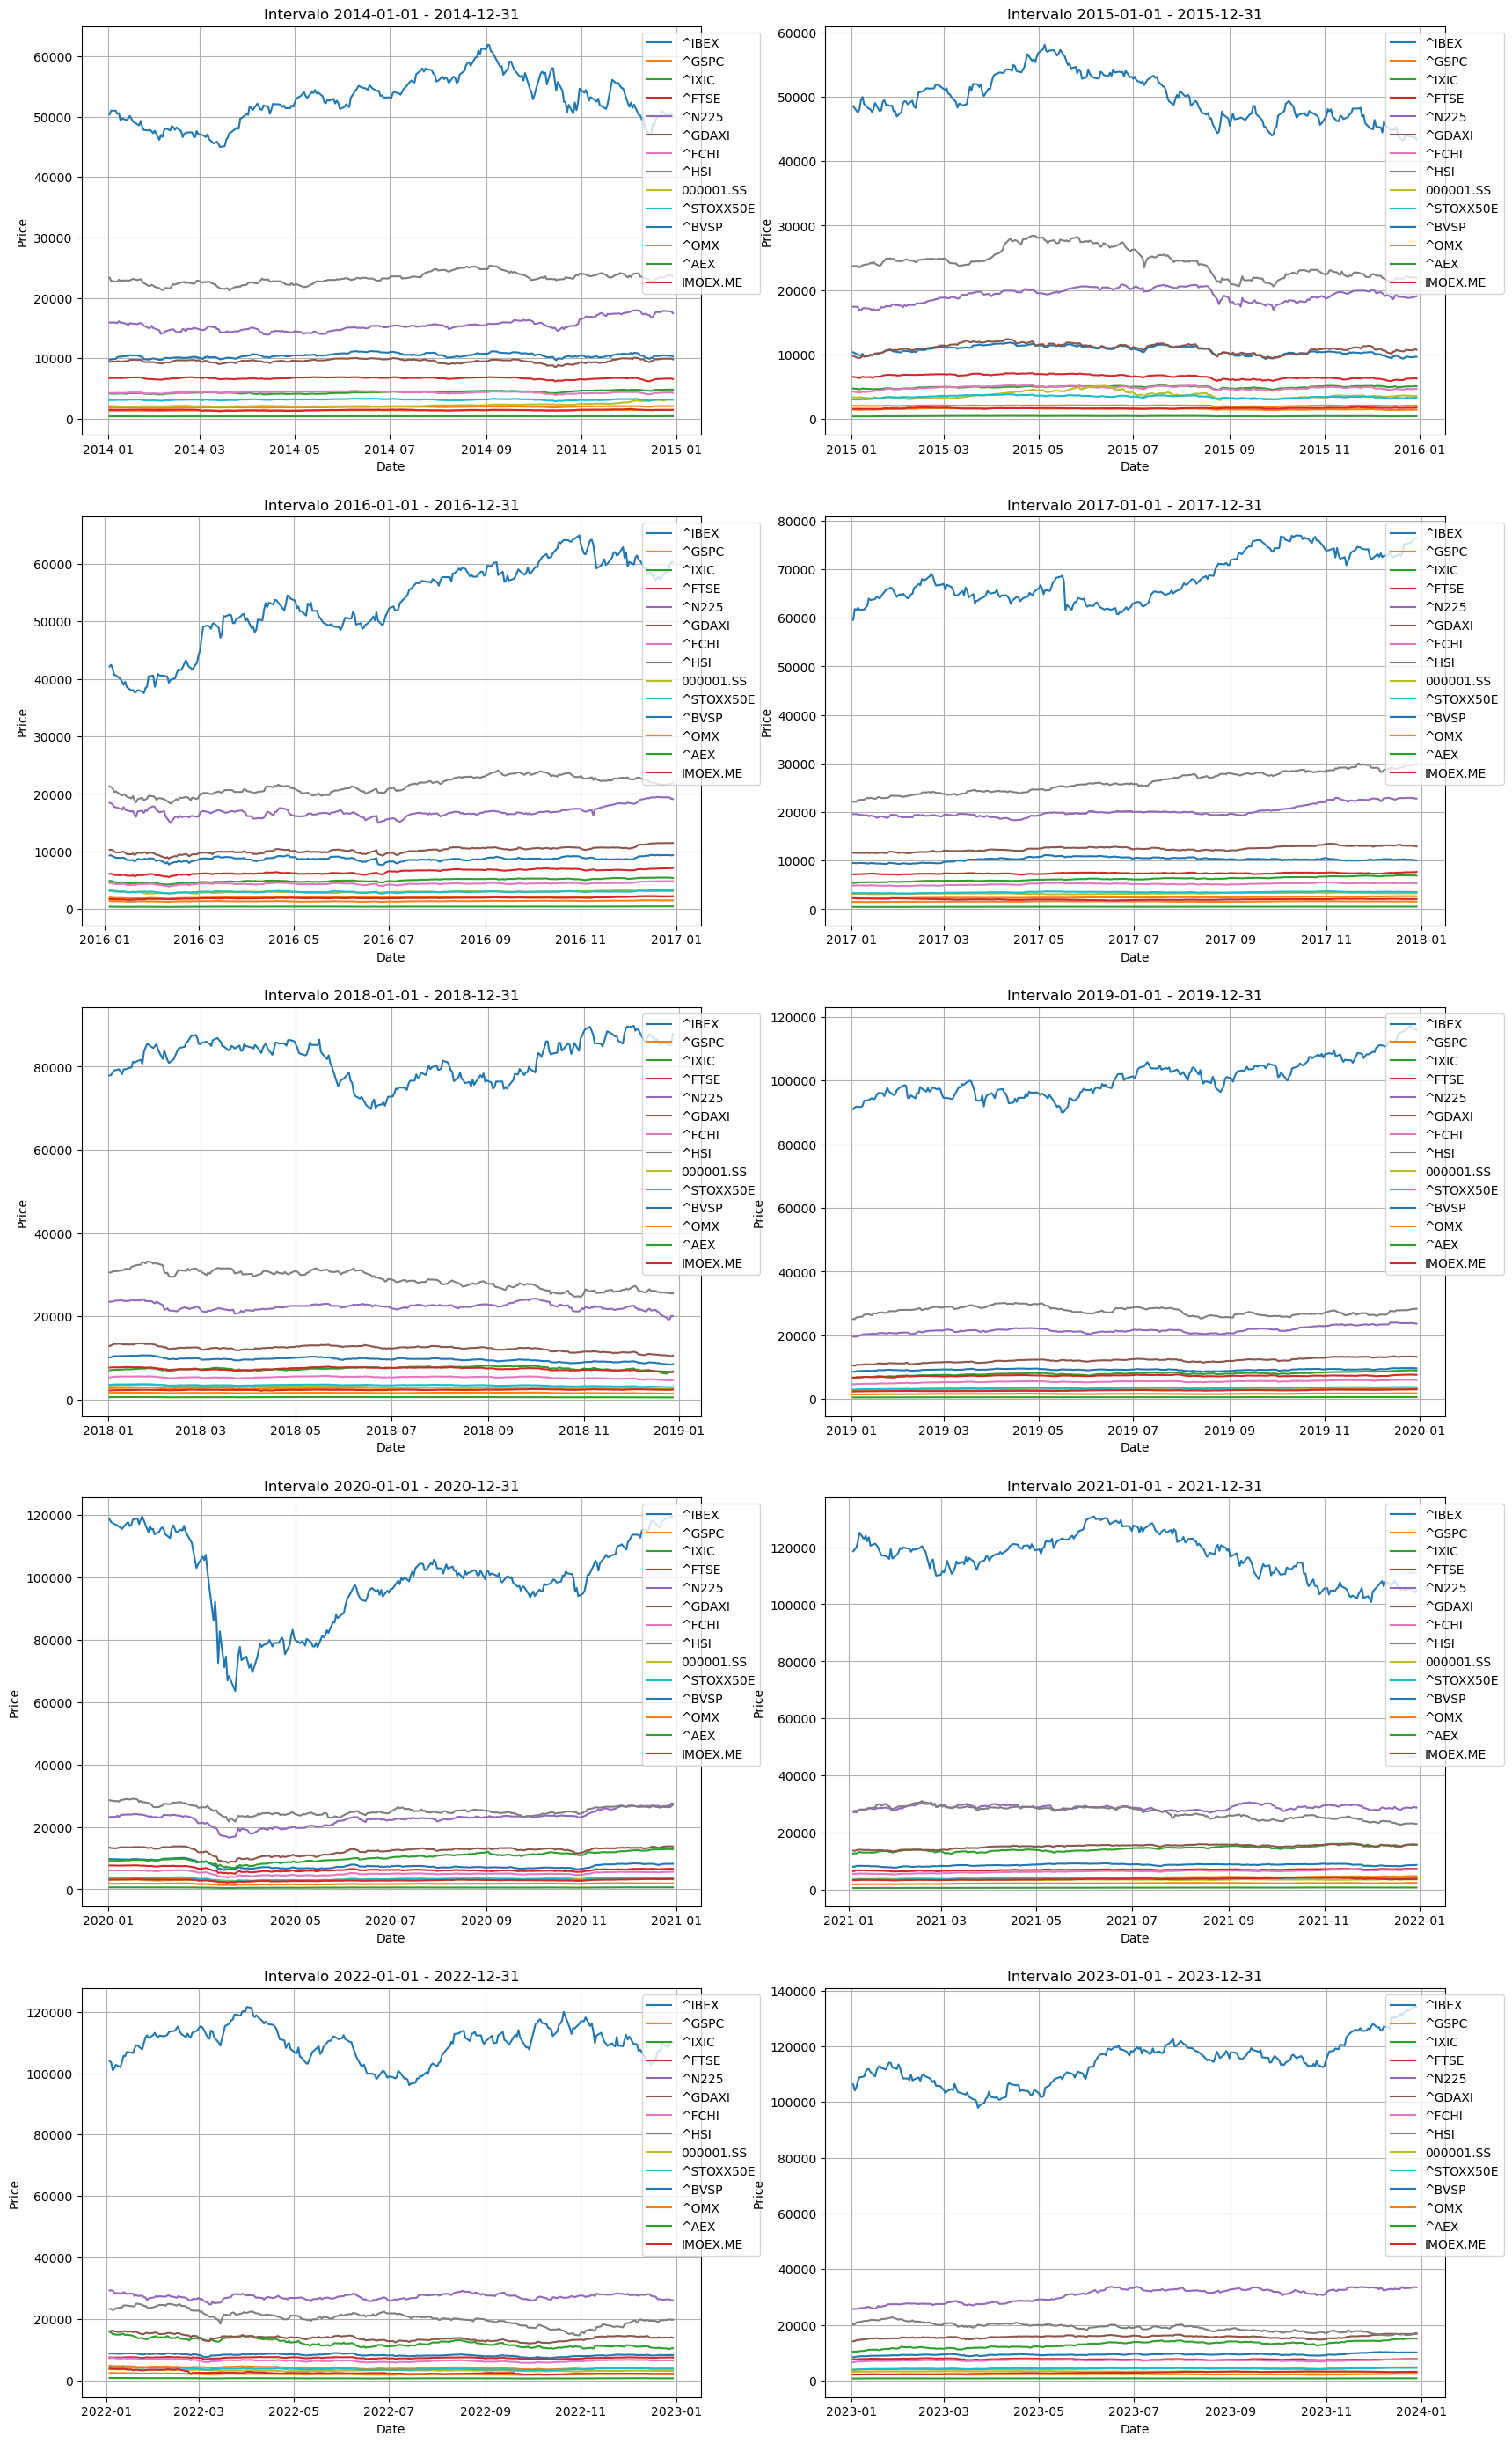

In [9]:
n_cols = 2
n_rows = max(len(data_set) // n_cols,1)
fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 7*n_rows))

for data, interval in zip(data_set, intervals):
    title = f"Intervalo {interval[0].date()} - {interval[1].date()}"
    i, j = divmod(intervals.index(interval), n_cols)
    if n_rows == 1:
        plot_data(data, axs[j], title)
    else:
        plot_data(data, axs[i, j], title)

In [10]:
# Coger las mus y sigmas de cada intervalo
mus = []
sigmas = []
for data, interval in zip(data_set, intervals):
    mu = data.get_period_return_mean_vector()
    sigma = data.get_period_return_covariance_matrix()
    print(f'Intervalo {interval[0].date()} - {interval[1].date()}')
    print("Expected returns")
    print(mu)
    mus.append(mu)
    sigmas.append(sigma)

Intervalo 2014-01-01 - 2014-12-31
Expected returns
[ 2.66383944e-04  5.17420422e-04  5.90363445e-04 -7.50664369e-05
  4.31226824e-04  2.16843286e-04  6.69560206e-05  6.28328312e-05
  1.62904862e-03  1.31892504e-04  8.99400288e-05  4.25373747e-04
  2.43381325e-04  6.20285813e-05]
Intervalo 2015-01-01 - 2015-12-31
Expected returns
[-1.82924714e-04  5.51583874e-05  3.22264282e-04 -1.09336670e-04
  4.26684517e-04  4.76787225e-04  4.67355486e-04 -2.36081325e-04
  5.28974671e-04  4.26620029e-04 -3.40711855e-04  2.94457170e-05
  3.01382150e-04  4.60589932e-04]
Intervalo 2016-01-01 - 2016-12-31
Expected returns
[ 0.00014433  0.00044349  0.00040801  0.00066698  0.00026759  0.00050656
  0.00036286  0.00018168 -0.0001435   0.0002415   0.00151065  0.00040334
  0.00050486  0.00101818]
Intervalo 2017-01-01 - 2017-12-31
Expected returns
[ 0.00024915  0.0006611   0.00094529  0.00027813  0.00060341  0.00043691
  0.00034713  0.00118454  0.00021869  0.00023397  0.00102696  0.00014413
  0.00045116 -0.0002

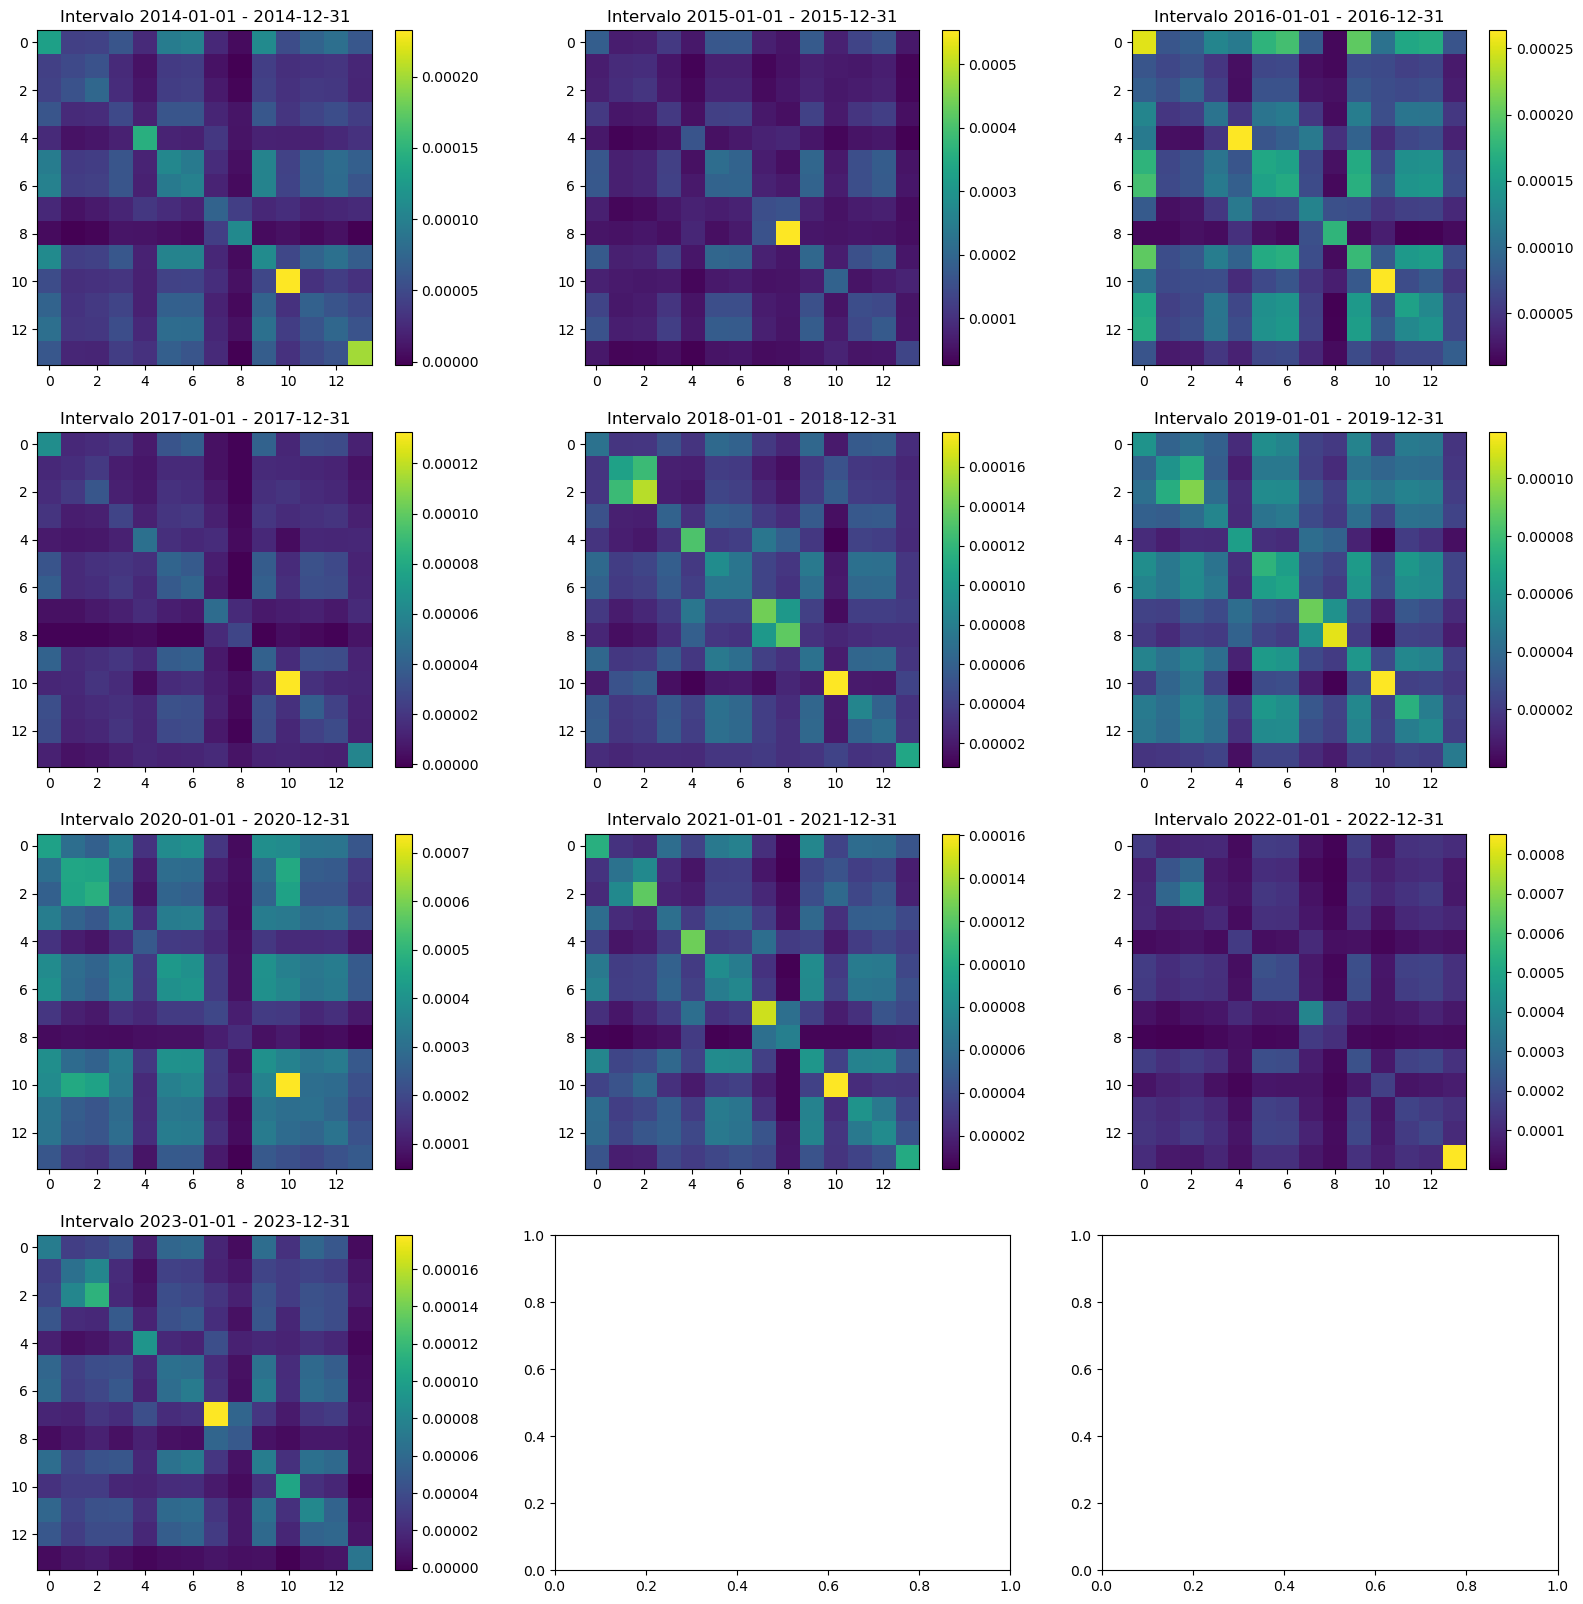

In [11]:
n_cols = 3
n_rows = max(len(sigmas) // n_cols + 1,1)
fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))
for sigma, interval in zip(sigmas, intervals):
    title = f"Intervalo {interval[0].date()} - {interval[1].date()}"
    i, j = divmod(intervals.index(interval), n_cols)
    if n_rows == 1:
        plot_covariance_matrix(sigma, axs[j], title)
        fig.colorbar(axs[j].imshow(sigma, interpolation="nearest"), ax=axs[j])
    else:
        plot_covariance_matrix(sigma, axs[i, j], title)
        fig.colorbar(axs[i, j].imshow(sigma, interpolation="nearest"), ax=axs[i, j])

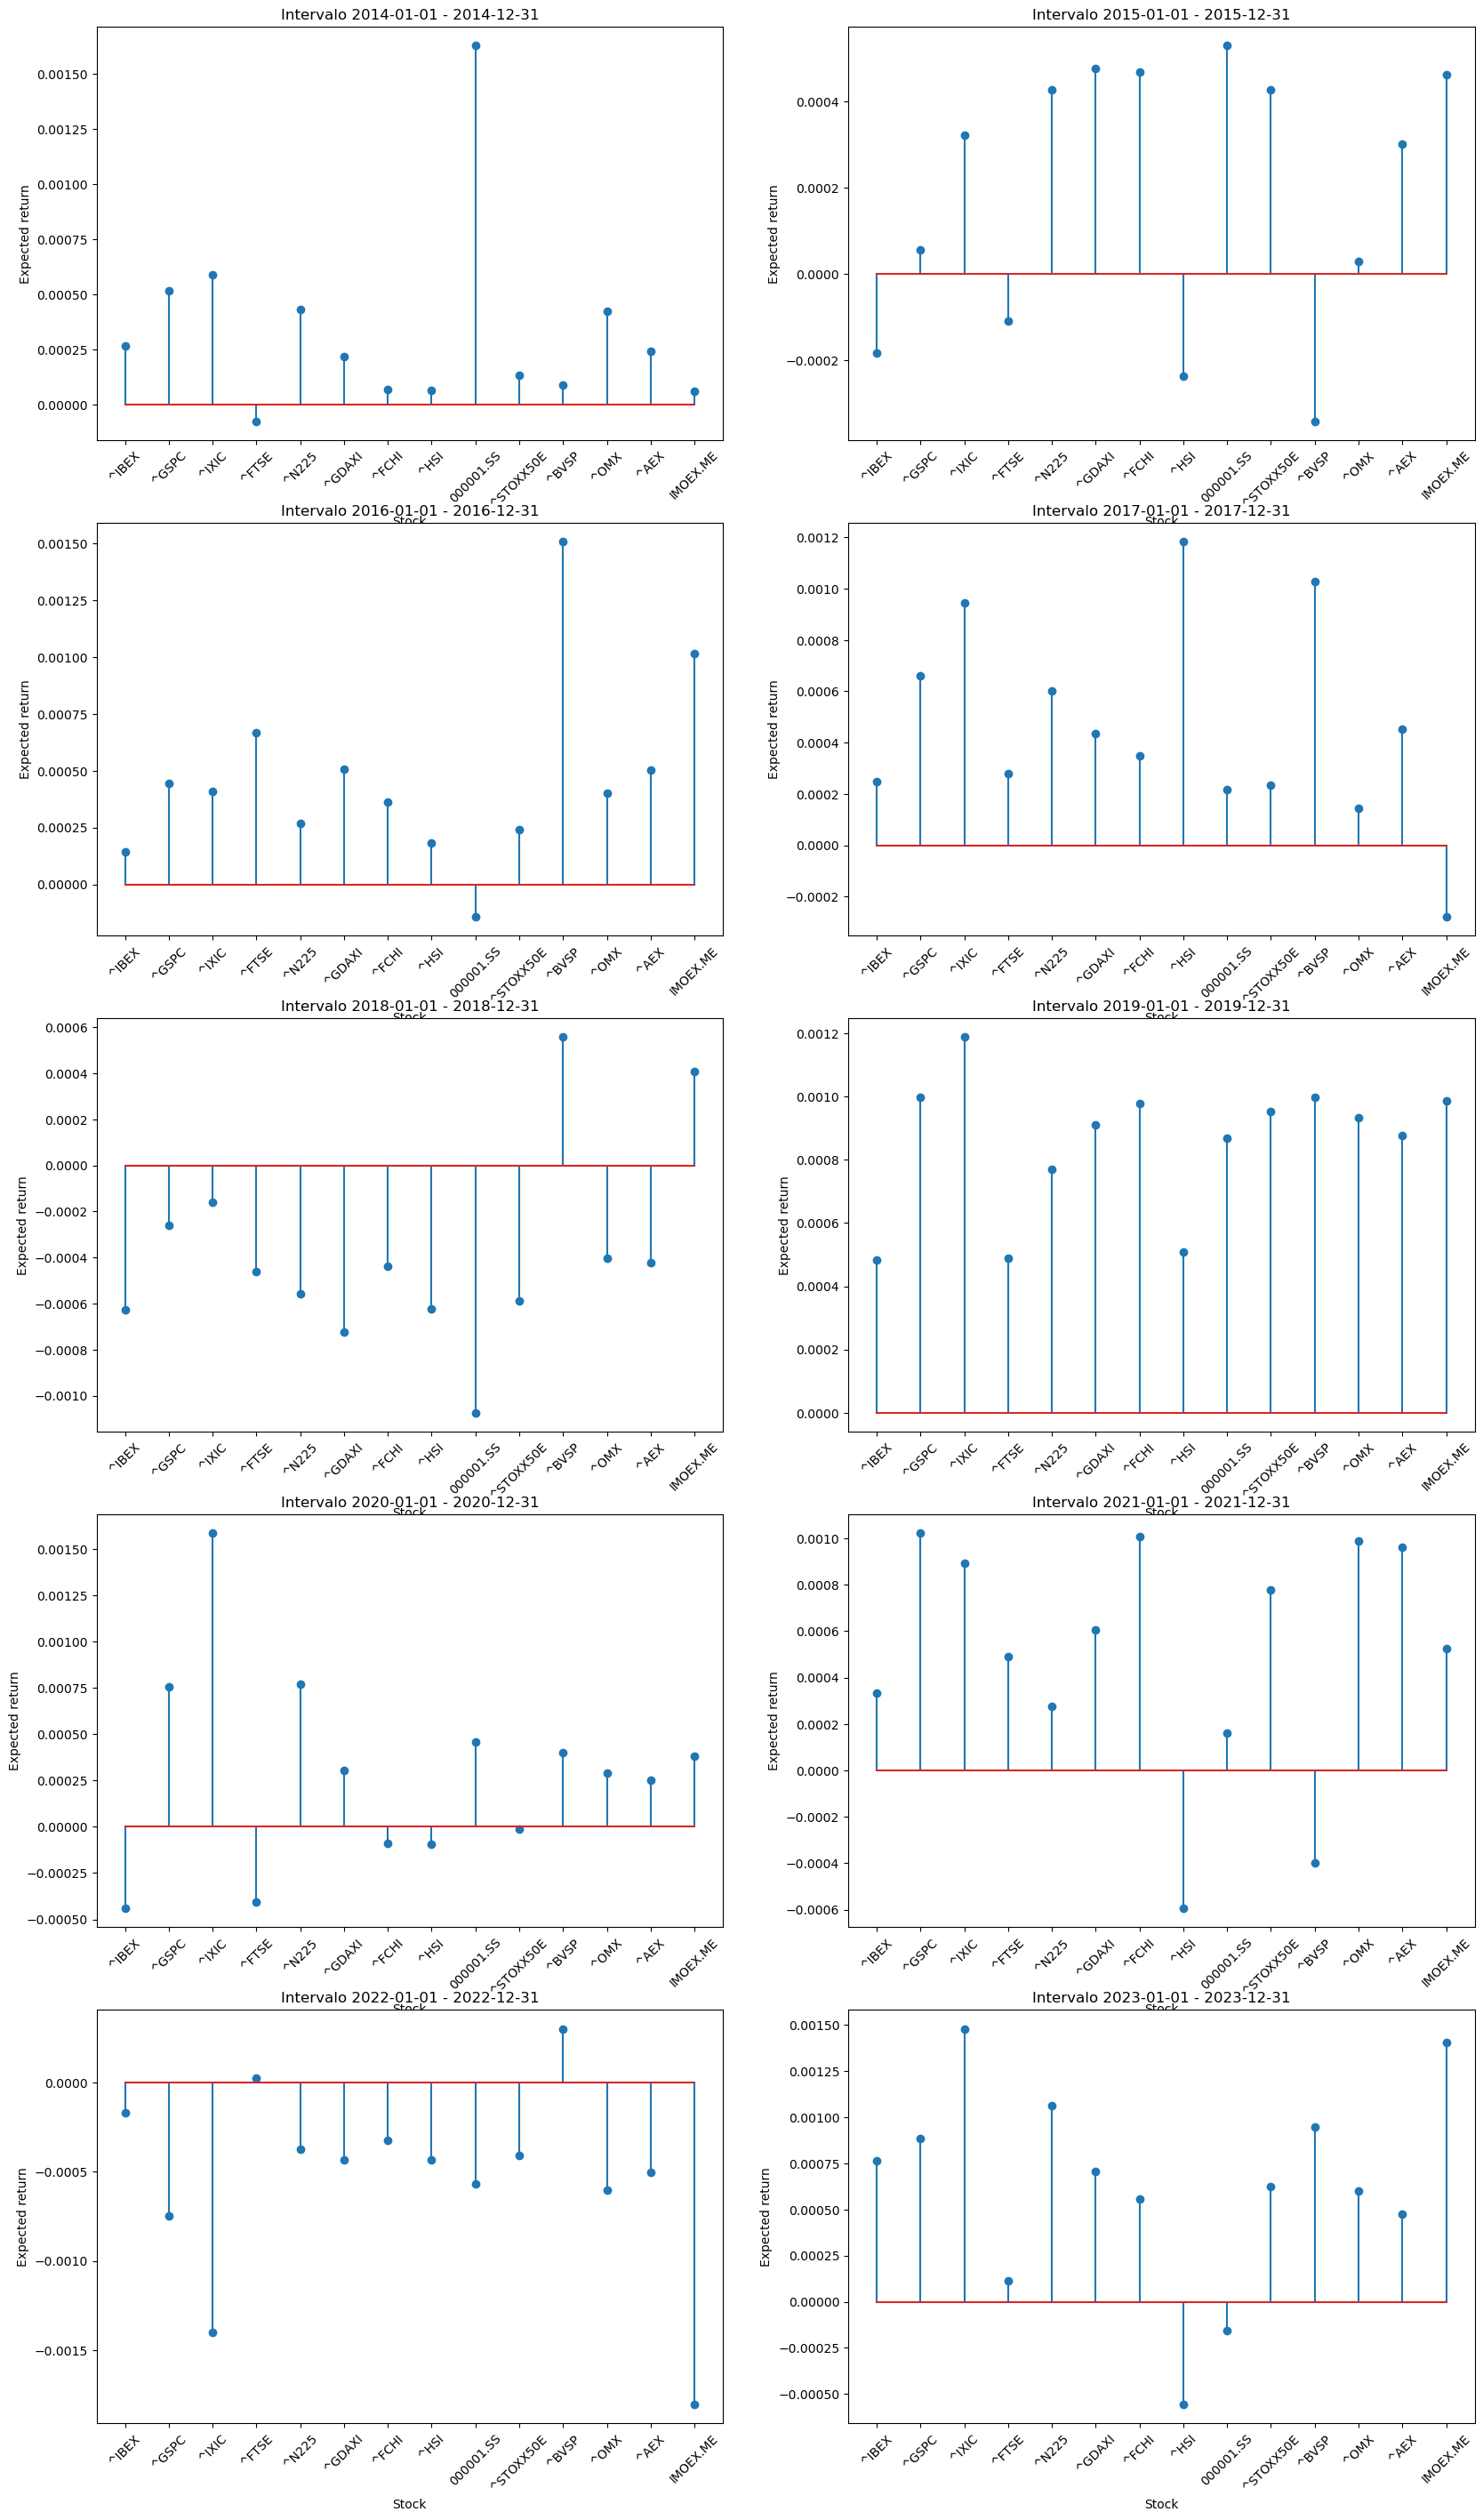

In [12]:
n_cols = 2
n_rows = max(len(mus) // n_cols,1)
fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 7*n_rows))

for mu, interval in zip(mus, intervals):
    title = f"Intervalo {interval[0].date()} - {interval[1].date()}"
    i, j = divmod(intervals.index(interval), n_cols)
    if n_rows == 1:
        plot_mu(data, mu, axs[j], title)
    else:
        plot_mu(data, mu, axs[i, j], title)

In [13]:
q = 0.5 # set risk factor
num_assets = len(ticker_names)
budget = num_assets // 3  # set budget
penalty = num_assets  # set parameter to scale the budget penalty term

portfolios = []
quad_programs = []
for mu, sigma, interval in zip(mus, sigmas, intervals):
    portfolio, qp = prepare_portfolio_optimization(q, budget, mu, sigma)
    portfolios.append(portfolio)
    quad_programs.append(qp)
    print(f'Intervalo {interval[0].date()} - {interval[1].date()}')
    print(qp.prettyprint())

Intervalo 2014-01-01 - 2014-12-31
Problem name: Portfolio optimization

Minimize
  6.574734087911844e-05*x_0^2 + 4.2183623856630986e-05*x_0*x_1
  + 5.1814265003935234e-05*x_0*x_10 + 7.217777603648248e-05*x_0*x_11
  + 8.373756075577816e-05*x_0*x_12 + 6.174547332950988e-05*x_0*x_13
  + 4.3862305537692255e-05*x_0*x_2 + 5.9986848097483414e-05*x_0*x_3
  + 2.5216459530643423e-05*x_0*x_4 + 9.665449092700162e-05*x_0*x_5
  + 0.00010122718507361659*x_0*x_6 + 2.4859841397299717e-05*x_0*x_7
  + 4.242833993644079e-06*x_0*x_8 + 0.00010987124847967885*x_0*x_9
  + 2.457086140536005e-05*x_1^2 + 2.9137024831219253e-05*x_1*x_10
  + 3.235009880812455e-05*x_1*x_11 + 3.386535869054147e-05*x_1*x_12
  + 2.3063649123779657e-05*x_1*x_13 + 5.697749539485434e-05*x_1*x_2
  + 2.6009957097186987e-05*x_1*x_3 + 9.526895888387818e-06*x_1*x_4
  + 3.763049763815607e-05*x_1*x_5 + 4.0545234375053415e-05*x_1*x_6
  + 8.830529858468494e-06*x_1*x_7 - 1.8051221772036108e-06*x_1*x_8
  + 4.155354555415484e-05*x_1*x_9 + 0.00011625

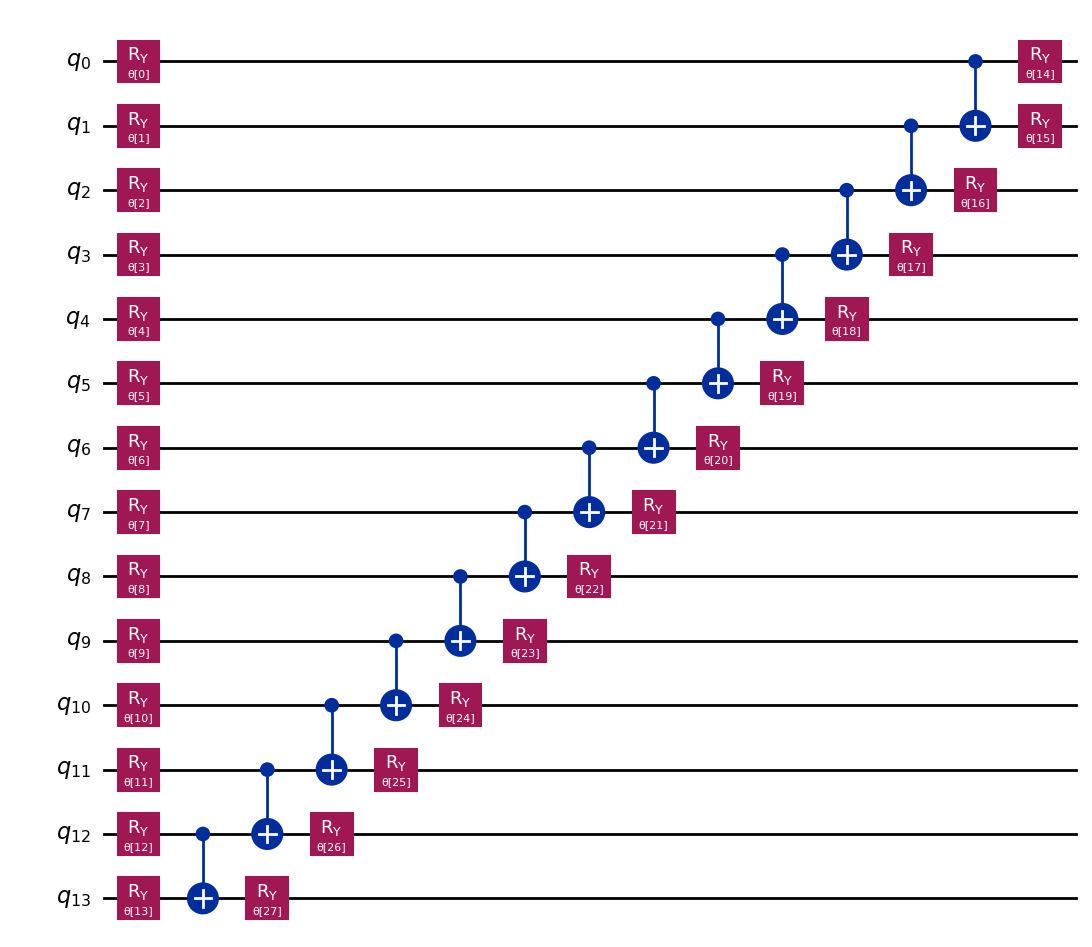

In [14]:
cobyla = COBYLA(maxiter=200)
ansatz = RealAmplitudes(num_assets, reps=1)
ansatz.decompose().draw(output="mpl",fold=-1)

In [15]:
results = []
for qp, interval in zip(quad_programs, intervals):
    print(f'Intervalo {interval[0].date()} - {interval[1].date()}')
    result = optimize(qp, ansatz, cobyla)
    results.append(result)
    print(result)

Intervalo 2014-01-01 - 2014-12-31
fval=-0.0022243941315648738, x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=0.0, x_5=0.0, x_6=0.0, x_7=1.0, x_8=1.0, x_9=0.0, x_10=0.0, x_11=0.0, x_12=0.0, x_13=0.0, status=SUCCESS
Intervalo 2015-01-01 - 2015-12-31
fval=-0.0008067571371909216, x_0=0.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=1.0, x_5=1.0, x_6=0.0, x_7=0.0, x_8=0.0, x_9=1.0, x_10=0.0, x_11=0.0, x_12=0.0, x_13=0.0, status=SUCCESS
Intervalo 2016-01-01 - 2016-12-31
fval=-0.0018942264468636578, x_0=0.0, x_1=0.0, x_2=0.0, x_3=0.0, x_4=0.0, x_5=1.0, x_6=0.0, x_7=1.0, x_8=0.0, x_9=0.0, x_10=1.0, x_11=0.0, x_12=1.0, x_13=0.0, status=SUCCESS
Intervalo 2017-01-01 - 2017-12-31
fval=-0.003045732914227876, x_0=0.0, x_1=0.0, x_2=0.0, x_3=0.0, x_4=1.0, x_5=1.0, x_6=0.0, x_7=1.0, x_8=0.0, x_9=0.0, x_10=1.0, x_11=0.0, x_12=0.0, x_13=0.0, status=SUCCESS
Intervalo 2018-01-01 - 2018-12-31
fval=0.0006263177206934372, x_0=1.0, x_1=0.0, x_2=0.0, x_3=0.0, x_4=1.0, x_5=0.0, x_6=0.0, x_7=0.0, x_8=0.0, x_9=0.0, x_10=1.0, x_11=0.

In [16]:
for result, portfolio, data, interval in zip(results, portfolios, data_set, intervals):
    print(f'Intervalo {interval[0].date()} - {interval[1].date()}')
    interpret_results(result, portfolio, data)


Intervalo 2014-01-01 - 2014-12-31
	Selected stocks:
	 - ^IBEX - ^IXIC - ^HSI - 000001.SS
	Expected value:  0.00255 Variance:  0.00065
Intervalo 2015-01-01 - 2015-12-31
	Selected stocks:
	 - ^IXIC - ^N225 - ^GDAXI - ^STOXX50E
	Expected value:  0.00165 Variance:  0.00169
Intervalo 2016-01-01 - 2016-12-31
	Selected stocks:
	 - ^GDAXI - ^HSI - ^BVSP - ^AEX
	Expected value:  0.0027 Variance:  0.00162
Intervalo 2017-01-01 - 2017-12-31
	Selected stocks:
	 - ^N225 - ^GDAXI - ^HSI - ^BVSP
	Expected value:  0.00325 Variance:  0.00041
Intervalo 2018-01-01 - 2018-12-31
	Selected stocks:
	 - ^IBEX - ^N225 - ^BVSP - IMOEX.ME
	Expected value:  -0.00022 Variance:  0.00081
Intervalo 2019-01-01 - 2019-12-31
	Selected stocks:
	 - ^IXIC - ^GDAXI - 000001.SS - ^BVSP
	Expected value:  0.00396 Variance:  0.00074
Intervalo 2020-01-01 - 2020-12-31
	Selected stocks:
	 - ^GSPC - ^IXIC - 000001.SS - IMOEX.ME
	Expected value:  0.00318 Variance:  0.00325
Intervalo 2021-01-01 - 2021-12-31
	Selected stocks:
	 - ^IXIC

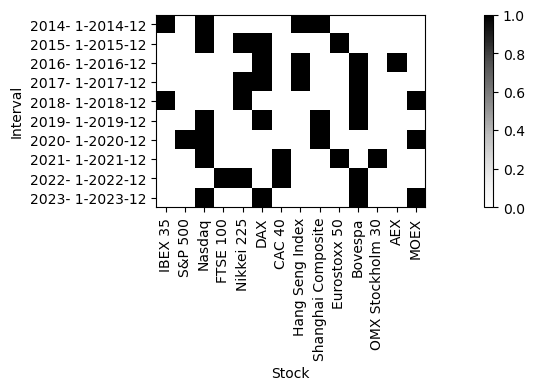

In [17]:
xs = [res.x for res in results]
# Plot the evolution of the portfolio as a bit map
plt.figure(figsize=(15, 0.25*len(xs)))
plt.imshow(xs, interpolation="nearest", cmap="Greys")
plt.xlabel("Stock")
plt.ylabel("Interval")
plt.xticks(range(len(ticker_names)), ticker_names.values(), rotation=90)
plt.yticks(range(len(xs)), [f"{interval[0].year}-{interval[0].month:2d}-{interval[1].year}-{interval[1].month:2d}" for interval in intervals])
plt.colorbar()
plt.show()

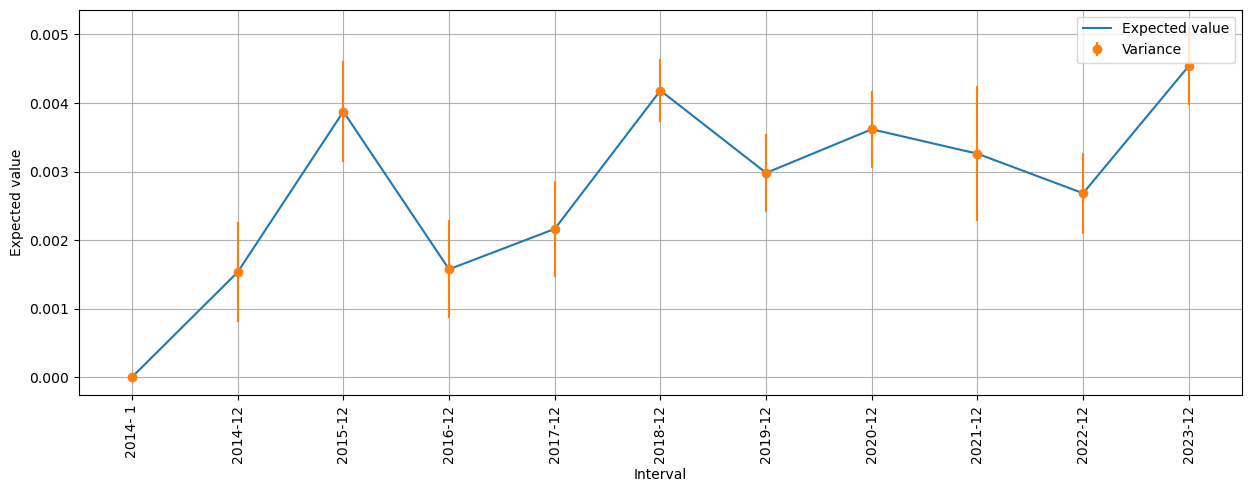

In [18]:
# Plot the progress of the expected value 
ys = [portfolio.portfolio_expected_value(res) for res in results]
vs = [portfolio.portfolio_variance(res) for res in results]
intervals2 = intervals.copy()

# Añadir valor inicial
ys.insert(0, 0)
vs.insert(0, 0)
intervals2.insert(0, (datetime.datetime(2014, 1, 1), datetime.datetime(2014, 1, 1)))

sds = [np.sqrt(v) for v in vs]

plt.figure(figsize=(15, 5))
# Plot the expected value
plt.plot(ys)
# Plot the variance as error bars
plt.errorbar(range(len(ys)), ys, yerr=vs, fmt="o")
plt.xlabel("Interval")
plt.ylabel("Expected value")
plt.xticks(range(len(ys)), [f"{interval[1].year}-{interval[1].month:2d}" for interval in intervals2], rotation=90)
plt.grid()
# Legend
plt.legend(["Expected value", "Variance"])
plt.show()

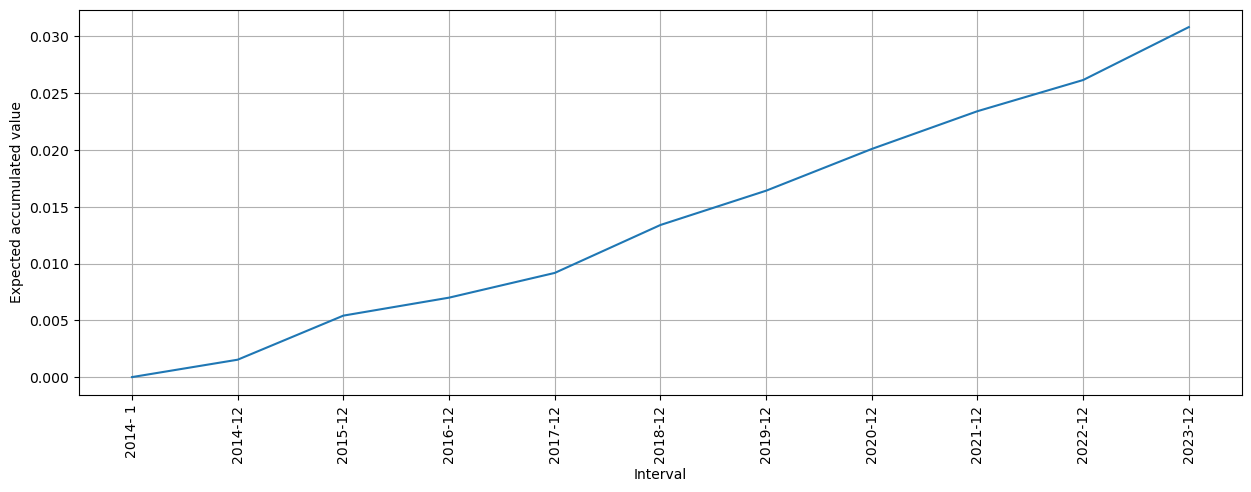

In [19]:
# With an investment of 1, the expected value of the accumulated portfolio is:
acum_ys = [1]
for i in range(1, len(ys)):
    acum_ys.append(acum_ys[-1] * (1 + ys[i]))
acum_ys = np.array(acum_ys)

# Remove the initial investment
acum_ys = acum_ys - 1

plt.figure(figsize=(15, 5))
plt.plot(acum_ys)
plt.xlabel("Interval")
plt.ylabel("Expected accumulated value")
plt.xticks(range(len(ys)), [f"{interval[1].year}-{interval[1].month:2d}" for interval in intervals2], rotation=90)
plt.grid()
plt.show()

In [ ]:
# Print the final accumulated value
print(f"Final accumulated value: {acum_ys[-1]}")